In [1]:
from pathlib import Path
import pickle

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

In [3]:
methods = {
    'sgd-rb-1': ('ogd', "olive", "dashdot"),
    'sgd-rb-10': ('r-sgd-10', plt.cm.Greens(0.9), "dashdot"),
    
    'adam-rb-1': ('r-adam-1', plt.cm.Reds(0.5), "--"),
    'adam-rb-10': ('r-adam-10', plt.cm.Reds(0.9), "--"),
    
    'fdekf': ('fdekf', 'black', "dotted"),
    'vdekf': ('vdekf', 'dimgray', "dotted"),
    
    'lofi-1': ('lofi-01', plt.cm.Blues(0.5), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.9), "-"),
}

n_iter = 100

# Figure 2(b), 21(b)

In [ ]:
# Set environmental variables
%env REBAYES_OUTPUT=./iid/fashion_mnist/mlp/nll
%env REBAYES_CONFIG=../configs/

# Run the script
# # To tune the hyperparameters:
# %run ../../run_regression_experiments.py --problem random-walk --tune --n_iter 100
%run ../../run_regression_experiments.py --problem random-walk --n_iter 100

In [4]:
path_fmnist_mlp = Path(Path.cwd(), "random-walk", "fashion_mnist", "mlp", "nll")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [10,]],
    "fdekf", "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_rmse_fmnist_mlp = {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    results_rmse_fmnist_mlp[method] = {
        "mean": jnp.mean(curr_result["window-metric"], axis=0),
        "std": jnp.std(curr_result["window-metric"], axis=0),
    }

In [5]:
def apply_convolve(x, kernel_size=10):
    left_pad = jnp.full(kernel_size // 2, x[0])
    right_pad = jnp.full(kernel_size // 2, x[-1])
    padded_data = jnp.concatenate([left_pad, x, right_pad])
    kernel = jnp.ones((kernel_size,)) / kernel_size
    smoothed = jnp.convolve(padded_data, kernel, mode='same')
    smoothed = smoothed[kernel_size//2:-kernel_size // 2]
    return smoothed

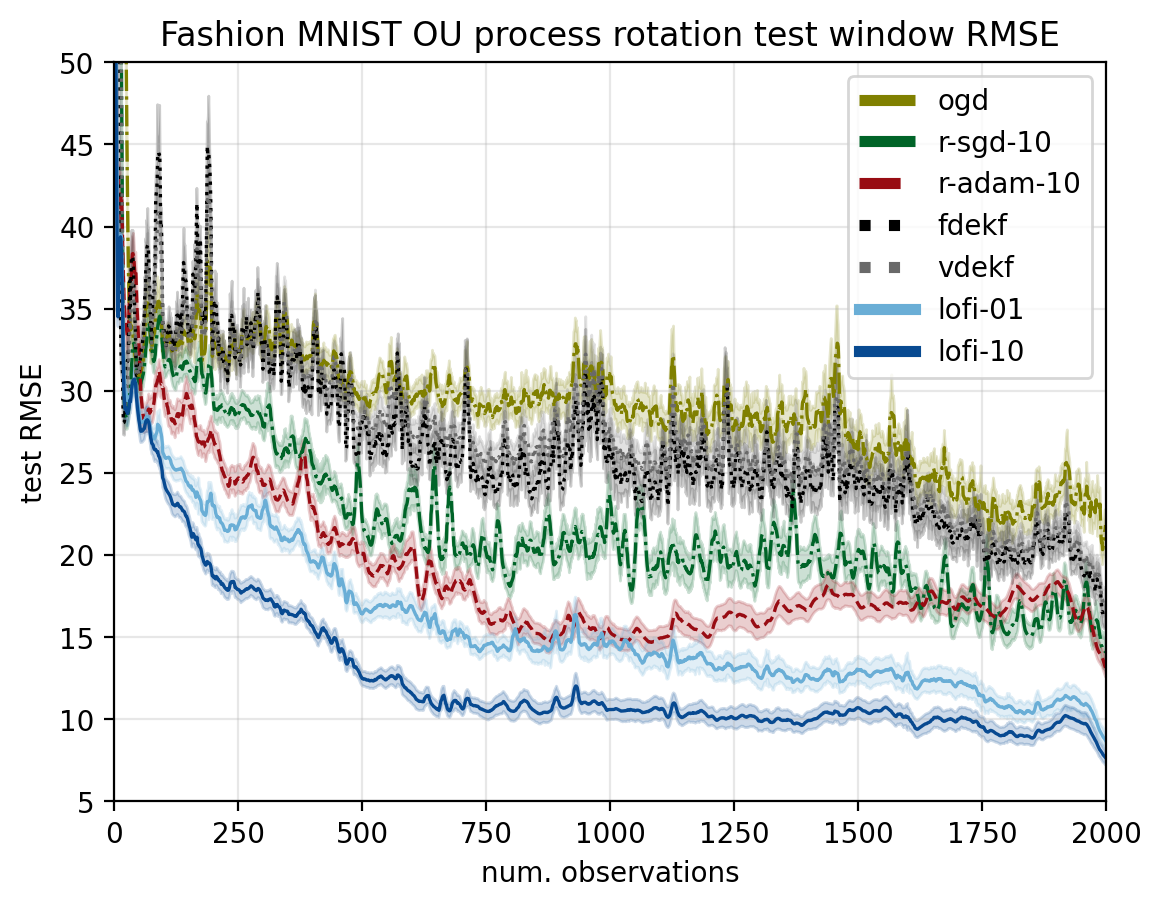

In [6]:
# RMSE
fig, ax = plt.subplots()
for key, val in results_rmse_fmnist_mlp.items():
    mean, std = apply_convolve(val['mean']), val['std']
    label, color, ls = methods[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test RMSE')
ax.set_xlim(0, 2_000)
ax.set_ylim(5, 50)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST OU process rotation test window RMSE')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp, 'fmnist-mlp-reg-test-rmse.pdf'), bbox_inches='tight')

# Figure 21(a)

In [7]:
methods_nlpd = {
    'sgd-rb-1': ('ogd-laplace', "olive", "dashdot"),
    'sgd-rb-10': ('r-sgd-10-laplace', plt.cm.Greens(0.9), "dashdot"),
    
    'adam-rb-1': ('r-adam-1-laplace', plt.cm.Reds(0.5), "--"),
    'adam-rb-10': ('r-adam-10-laplace', plt.cm.Reds(0.9), "--"),
    
    'fdekf': ('fdekf', 'black', "dotted"),
    'vdekf': ('vdekf', 'dimgray', "dotted"),
    
    'lofi-1': ('lofi-01', plt.cm.Blues(0.5), "-"),
    'lofi-10': ('lofi-10', plt.cm.Blues(0.9), "-"),
}

n_iter = 100

In [8]:
path_fmnist_mlp_nlpd = Path(Path.cwd(), "random-walk", "fashion_mnist", "mlp", "nlpd-linearized")

agents_fmnist_mlp = (
    *[f"sgd-rb-{rank}" for rank in [1, 10,]],
    *[f"adam-rb-{rank}" for rank in [10,]],
    "fdekf", "vdekf",
    *[f"lofi-{rank}" for rank in [1, 10,]],
)

results_nlpd_fmnist_mlp = {}

for method in agents_fmnist_mlp:
    with open(Path(path_fmnist_mlp_nlpd, f'{method}.pkl'), "rb") as f:
        curr_result = pickle.load(f)
    results_nlpd_fmnist_mlp[method] = {
        "mean": jnp.nanmean(curr_result["nlpd"], axis=0),
        "std": jnp.nanstd(curr_result["nlpd"], axis=0),
    }

In [9]:
def apply_convolve(x, kernel_size=10):
    left_pad = jnp.full(kernel_size // 2, x[0])
    right_pad = jnp.full(kernel_size // 2, x[-1])
    padded_data = jnp.concatenate([left_pad, x, right_pad])
    kernel = jnp.ones((kernel_size,)) / kernel_size
    smoothed = jnp.convolve(padded_data, kernel, mode='same')
    smoothed = smoothed[kernel_size//2:-kernel_size // 2]
    return smoothed

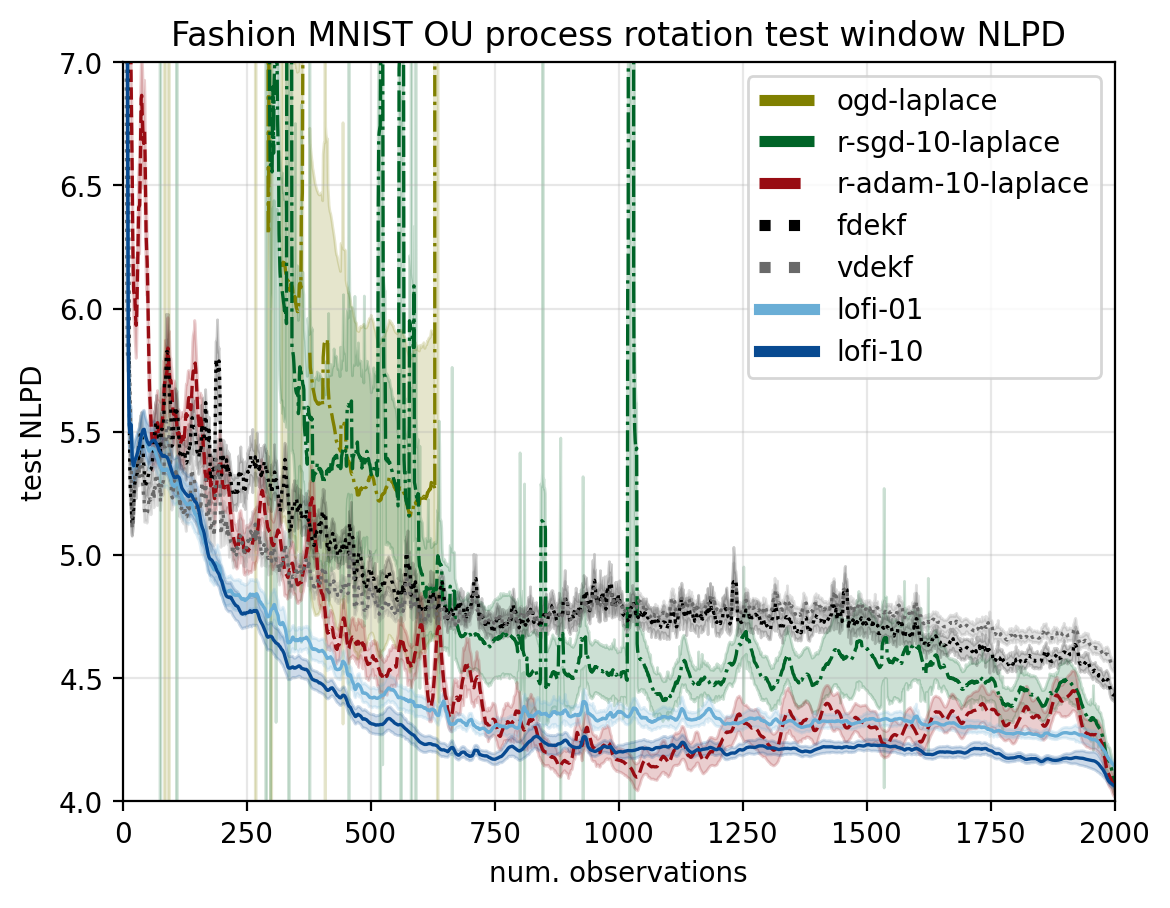

In [10]:
# NLPD-MC
fig, ax = plt.subplots()
for key, val in results_nlpd_fmnist_mlp.items():
    mean, std = apply_convolve(val['mean']), val['std']
    label, color, ls = methods_nlpd[key]
    ax.plot(mean, label=label, c=color, linewidth=1.2, linestyle=ls)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std / jnp.sqrt(n_iter),
        mean + std / jnp.sqrt(n_iter),
        alpha=0.2,
        color=color
    )
ax.set_xlabel('num. observations')
ax.set_ylabel('test NLPD')
ax.set_xlim(0, 2_000)
ax.set_ylim(4.0, 7.0)
ax.grid(alpha=0.3)
ax.set_title('Fashion MNIST OU process rotation test window NLPD')
leg = ax.legend()
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.savefig(Path(path_fmnist_mlp_nlpd, 'fmnist-mlp-reg-test-nlpd.pdf'), bbox_inches='tight')